## Import libraries

In [36]:
main_folder_path = '../../../'

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Transform google open buildings's geometry
from shapely import wkt

# Correlation calc
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(main_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Notebook config

In [3]:
city = 'Merida'
projected_crs = 'EPSG:32616' #Mérida

## Create area of interest

In [4]:
# Load city's hex res 8
hex_schema = 'hexgrid'
hex_table = 'hexgrid_8_city_2020'
hex_type = 'urban'

hex_query = f"SELECT * FROM {hex_schema}.{hex_table} WHERE \"city\" LIKE \'{city}\' AND \"type\" LIKE \'{hex_type}\'"
hex_gdf = aup.gdf_from_query(hex_query, geometry_col='geometry')

# Show
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(2)

EPSG:4326
(718, 6)


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type
0,8845098099fffff,"POLYGON ((-89.45301 20.81926, -89.44854 20.821...",31002,Acanceh,Merida,urban
1,88450980d9fffff,"POLYGON ((-89.45762 20.7967, -89.45316 20.7992...",31002,Acanceh,Merida,urban


EPSG:4326
(1, 6)


<Axes: >

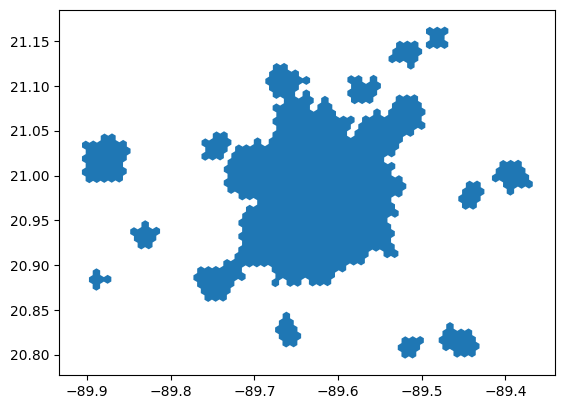

In [5]:
aoi = hex_gdf.dissolve()

# Show
print(aoi.crs)
print(aoi.shape)
aoi.plot()

## Find all blocks within reach of area of interest

#### Load city's blocks

In [6]:
# Create a list from a list with all unique cvegeo_mun ('CVE_ENT'+'CVE_MUN') of current city
cvegeo_mun_lst = list(hex_gdf.CVEGEO.unique())

# Load city municipality's blocks
blocks_schema = 'marco'
blocks_table = 'mza_2020'

blocks_gdf = gpd.GeoDataFrame()
for cvegeo_mun in cvegeo_mun_lst:
    
    blocks_query = f"SELECT * FROM {blocks_schema}.{blocks_table} WHERE \"CVEGEO\" LIKE \'{cvegeo_mun}%\'"
    mun_blocks_gdf = aup.gdf_from_query(blocks_query, geometry_col='geometry')
    blocks_gdf = pd.concat([blocks_gdf,mun_blocks_gdf])
    
# Show
print(blocks_gdf.crs)
print(blocks_gdf.shape)
blocks_gdf.head(2)

EPSG:4326
(23145, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,3100200110053013,31,002,0011,0053,013,Rural,Típica,"POLYGON ((-89.44142 20.88801, -89.43981 20.887..."
1,3100200020053013,31,002,0002,0053,013,Rural,Típica,"POLYGON ((-89.42898 20.86323, -89.42907 20.863..."


#### Blocks that touch area of interest

In [7]:
# Keep blocks that touch the area of interest
aoi_union = aoi.union_all()  # Create shapely object
blocks_aoi_gdf = blocks_gdf[blocks_gdf.intersects(aoi_union)].copy()

# Show
print(blocks_aoi_gdf.crs)
print(blocks_aoi_gdf.shape)
blocks_aoi_gdf.head(2)

EPSG:4326
(21277, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
2,3100200010091007,31,002,0001,0091,007,Urbana,Típica,"POLYGON ((-89.45058 20.8127, -89.4505 20.81268..."
5,3100200010034025,31,002,0001,0034,025,Urbana,Típica,"POLYGON ((-89.45444 20.81015, -89.45383 20.809..."


<Axes: >

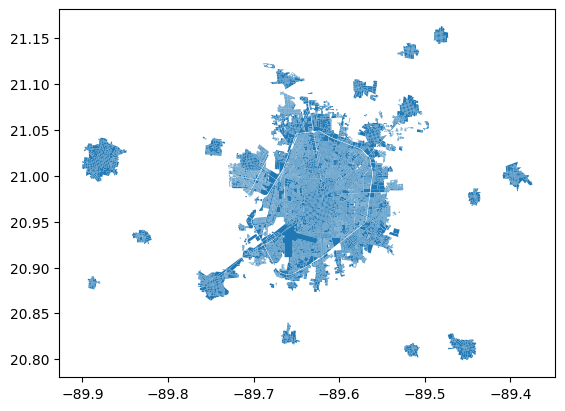

In [8]:
blocks_aoi_gdf.plot()

## Load google buildings

In [9]:
# Load csv
buildings_df = pd.read_csv(main_folder_path+'data/external/google_open_buildings/8f5_buildings.csv')
# Turn into GeoDataFrame
buildings_df['geometry'] = buildings_df['geometry'].apply(wkt.loads)
buildings_gdf = gpd.GeoDataFrame(buildings_df, geometry='geometry', crs='EPSG:4326')
del buildings_df

# Show
print(buildings_gdf.crs)
print(buildings_gdf.shape)
buildings_gdf.head(2)

EPSG:4326
(3244124, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
0,20.913590,-89.743828,71.6770,0.7033,"POLYGON ((-89.74381 20.91354, -89.74378 20.913...",76GGW774+CFMG
1,21.150262,-88.165895,20.3107,0.6709,"POLYGON ((-88.16587 21.15028, -88.1659 21.1502...",76HH5R2M+4J5F


## Filter for google buildings within reach of blocks located within area of interest

### Filter

In [29]:
# Spatial join between buildings and blocks
buildings_aoi_gdf = gpd.sjoin(buildings_gdf, blocks_aoi_gdf, how='inner', predicate='intersects')
# Drop extra cols
buildings_aoi_gdf = buildings_aoi_gdf.drop(columns=['index_right'])

# Show
print(buildings_aoi_gdf.crs)
print(buildings_aoi_gdf.shape)
buildings_aoi_gdf.head(2)

EPSG:4326
(987761, 14)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
7,21.023225,-89.879738,19.8499,0.8195,"POLYGON ((-89.87971 21.02324, -89.87975 21.023...",76HG24FC+74JV,310380001008A022,31,038,0001,008A,022,Urbana,Típica
10,20.916671,-89.624195,13.1274,0.6835,"POLYGON ((-89.62418 20.91665, -89.62418 20.916...",76GGW98G+M87X,3105000015121016,31,050,0001,5121,016,Urbana,Típica


### Remove duplicated blocks (Which happens whenever a building touches two or more blocks)

#### __SHOW__ - Buildings that touch two or more blocks test

In [30]:
buildings_aoi_gdf.loc[buildings_aoi_gdf.full_plus_code.duplicated()]

,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
175,21.000608,-89.648010,228.2214,0.7898,"POLYGON ((-89.64791 21.00063, -89.64805 21.000...",76HG2922+6QX8,3105000011913044,31,050,0001,1913,044,Urbana,Típica
2295,20.987470,-89.704474,58.6492,0.8392,"POLYGON ((-89.70442 20.98746, -89.70448 20.987...",76GGX7PW+X6JX,310500001683A043,31,050,0001,683A,043,Urbana,Típica
6075,20.880707,-89.757533,36.7019,0.8416,"POLYGON ((-89.75749 20.8807, -89.75752 20.8807...",76GGV6JR+7XP9,3110100010189033,31,101,0001,0189,033,Urbana,Típica
8026,21.062817,-89.663447,288.1735,0.7881,"POLYGON ((-89.66336 21.06274, -89.66338 21.062...",76HG387P+4JFP,3105000016914017,31,050,0001,6914,017,Urbana,Típica
11554,21.027194,-89.683598,107.3897,0.7670,"POLYGON ((-89.68353 21.02721, -89.68361 21.027...",76HG28G8+VHCQ,3105000016793013,31,050,0001,6793,013,Urbana,Típica
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229510,21.028567,-89.688209,33.1412,0.6929,"POLYGON ((-89.68817 21.02857, -89.68819 21.028...",76HG28H6+CPFM,3105000016793026,31,050,0001,6793,026,Urbana,Típica
3236179,21.059086,-89.610367,6.2986,0.7245,"POLYGON ((-89.61035 21.05908, -89.61036 21.059...",76HG395Q+JVJF,3105000014960022,31,050,0001,4960,022,Urbana,Típica
3236271,21.045187,-89.662387,46.1652,0.8245,"POLYGON ((-89.66234 21.04517, -89.66237 21.045...",76HG28WQ+32HG,3105000016098001,31,050,0001,6098,001,Urbana,Típica
3237889,20.981693,-89.706403,44.2843,0.7968,"POLYGON ((-89.70636 20.98169, -89.70639 20.981...",76GGX7JV+MCHJ,3105000014462007,31,050,0001,4462,007,Urbana,Típica


In [31]:
buildings_test = buildings_aoi_gdf.loc[buildings_aoi_gdf.full_plus_code=='76HG2922+6QX8'].copy()
buildings_test

,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
175,21.000608,-89.64801,228.2214,0.7898,"POLYGON ((-89.64791 21.00063, -89.64805 21.000...",76HG2922+6QX8,3105000011913030,31,050,0001,1913,030,Urbana,Típica
175,21.000608,-89.64801,228.2214,0.7898,"POLYGON ((-89.64791 21.00063, -89.64805 21.000...",76HG2922+6QX8,3105000011913044,31,050,0001,1913,044,Urbana,Típica


In [32]:
touched_blocks = ['3105000011913030','3105000011913044']
blocks_test = blocks_aoi_gdf.loc[blocks_aoi_gdf.CVEGEO.isin(touched_blocks)].copy()
blocks_test

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
10353,3105000011913044,31,050,0001,1913,044,Urbana,Típica,"POLYGON ((-89.64817 21.00059, -89.64877 21.000..."
10406,3105000011913030,31,050,0001,1913,030,Urbana,Típica,"POLYGON ((-89.64795 21.00051, -89.64769 21.001..."


<Axes: >

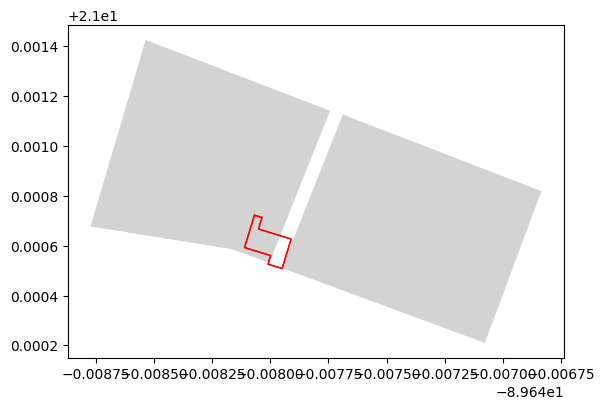

In [33]:
fig,ax=plt.subplots()

buildings_test.plot(ax=ax,
                    facecolor="none",
                    edgecolor='red',
                    zorder=1)
blocks_test.plot(ax=ax,
                 color='lightgrey',
                 zorder=0)

#### __REMOVE__

In [35]:
buildings_aoi_gdf_f = buildings_aoi_gdf.copy()
buildings_aoi_gdf_f.drop_duplicates('full_plus_code',inplace=True)

# Show
print(buildings_aoi_gdf_f.crs)
print(buildings_aoi_gdf_f.shape)
buildings_aoi_gdf_f.head(2)

EPSG:4326
(986036, 14)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
7,21.023225,-89.879738,19.8499,0.8195,"POLYGON ((-89.87971 21.02324, -89.87975 21.023...",76HG24FC+74JV,310380001008A022,31,038,0001,008A,022,Urbana,Típica
10,20.916671,-89.624195,13.1274,0.6835,"POLYGON ((-89.62418 20.91665, -89.62418 20.916...",76GGW98G+M87X,3105000015121016,31,050,0001,5121,016,Urbana,Típica


## For those blocks...

In [40]:
# Overlay buildings with blocks
# (This spatial intersection, creates split buildings with data from the original building and the block it falls in)
buildings_blocks_overlay = gpd.overlay(df1=buildings_aoi_gdf_f[['full_plus_code','geometry']], df2=blocks_aoi_gdf, how="intersection")



# Show
print(buildings_blocks_overlay.crs)
print(buildings_blocks_overlay.shape)
buildings_blocks_overlay.head(2)

EPSG:4326
(987753, 10)


,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,76HG24FC+74JV,310380001008A022,31,038,0001,008A,022,Urbana,Típica,"POLYGON ((-89.87972 21.0232, -89.87976 21.0232..."
1,76GGW98G+M87X,3105000015121016,31,050,0001,5121,016,Urbana,Típica,"POLYGON ((-89.62421 20.91665, -89.62421 20.916..."


In [41]:
buildings_blocks_overlay.loc[buildings_blocks_overlay.full_plus_code.duplicated()]

,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
58,76HG2922+6QX8,3105000011913030,31,050,0001,1913,030,Urbana,Típica,"POLYGON ((-89.64795 21.00051, -89.64795 21.000..."
696,76GGX7PW+X6JX,310500001683A041,31,050,0001,683A,041,Urbana,Típica,"POLYGON ((-89.70442 20.98746, -89.70447 20.987..."
1839,76GGV6JR+7XP9,3110100010189033,31,101,0001,0189,033,Urbana,Típica,"POLYGON ((-89.75757 20.88071, -89.75753 20.880..."
2415,76HG387P+4JFP,3105000016083065,31,050,0001,6083,065,Urbana,Típica,"POLYGON ((-89.66347 21.06272, -89.66347 21.062..."
3526,76HG28G8+VHCQ,3105000016793013,31,050,0001,6793,013,Urbana,Típica,"POLYGON ((-89.68353 21.02721, -89.68361 21.027..."
...,...,...,...,...,...,...,...,...,...,...
983281,76HG28H6+CPFM,3105000016793028,31,050,0001,6793,028,Urbana,Típica,"POLYGON ((-89.68823 21.02853, -89.68825 21.028..."
985341,76HG395Q+JVJF,3105000014960022,31,050,0001,4960,022,Urbana,Típica,"POLYGON ((-89.61038 21.05909, -89.61036 21.059..."
985371,76HG28WQ+32HG,3105000016098029,31,050,0001,6098,029,Urbana,Típica,"POLYGON ((-89.66237 21.04523, -89.66237 21.045..."
985862,76GGX7JV+MCHJ,3105000014462016,31,050,0001,4462,016,Urbana,Típica,"POLYGON ((-89.70641 20.98165, -89.70645 20.981..."


In [42]:
buildingblocks_test = buildings_blocks_overlay.loc[buildings_blocks_overlay.full_plus_code=='76HG2922+6QX8'].copy()
buildingblocks_test

,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
57,76HG2922+6QX8,3105000011913044,31,050,0001,1913,044,Urbana,Típica,"POLYGON ((-89.648 21.00056, -89.64811 21.00059..."
58,76HG2922+6QX8,3105000011913030,31,050,0001,1913,030,Urbana,Típica,"POLYGON ((-89.64795 21.00051, -89.64795 21.000..."


In [43]:
touched_blocks = ['3105000011913044','3105000011913030']
blocks_test = blocks_aoi_gdf.loc[blocks_aoi_gdf.CVEGEO.isin(touched_blocks)].copy()
blocks_test

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
10353,3105000011913044,31,050,0001,1913,044,Urbana,Típica,"POLYGON ((-89.64817 21.00059, -89.64877 21.000..."
10406,3105000011913030,31,050,0001,1913,030,Urbana,Típica,"POLYGON ((-89.64795 21.00051, -89.64769 21.001..."


<Axes: >

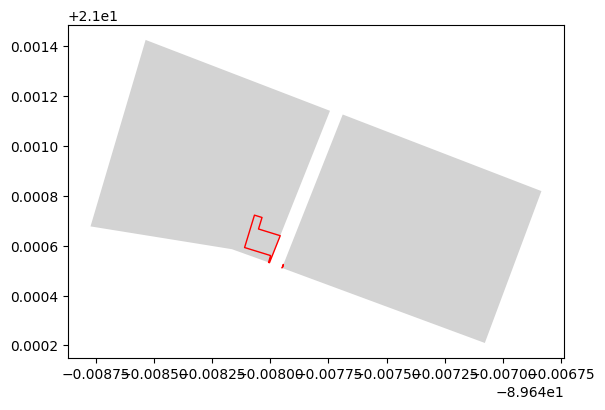

In [44]:
fig,ax=plt.subplots()

buildingblocks_test.plot(ax=ax,
                    facecolor="none",
                    edgecolor='red',
                    zorder=1)
blocks_test.plot(ax=ax,
                 color='lightgrey',
                 zorder=0)